In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino
## Lecture 02 - Naive Bayes

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from scipy.stats import norm

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [5]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [6]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## DataSet

In [7]:
# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names
iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, 
                      header=None, names = iris_features)

In [8]:
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### distribution of the data

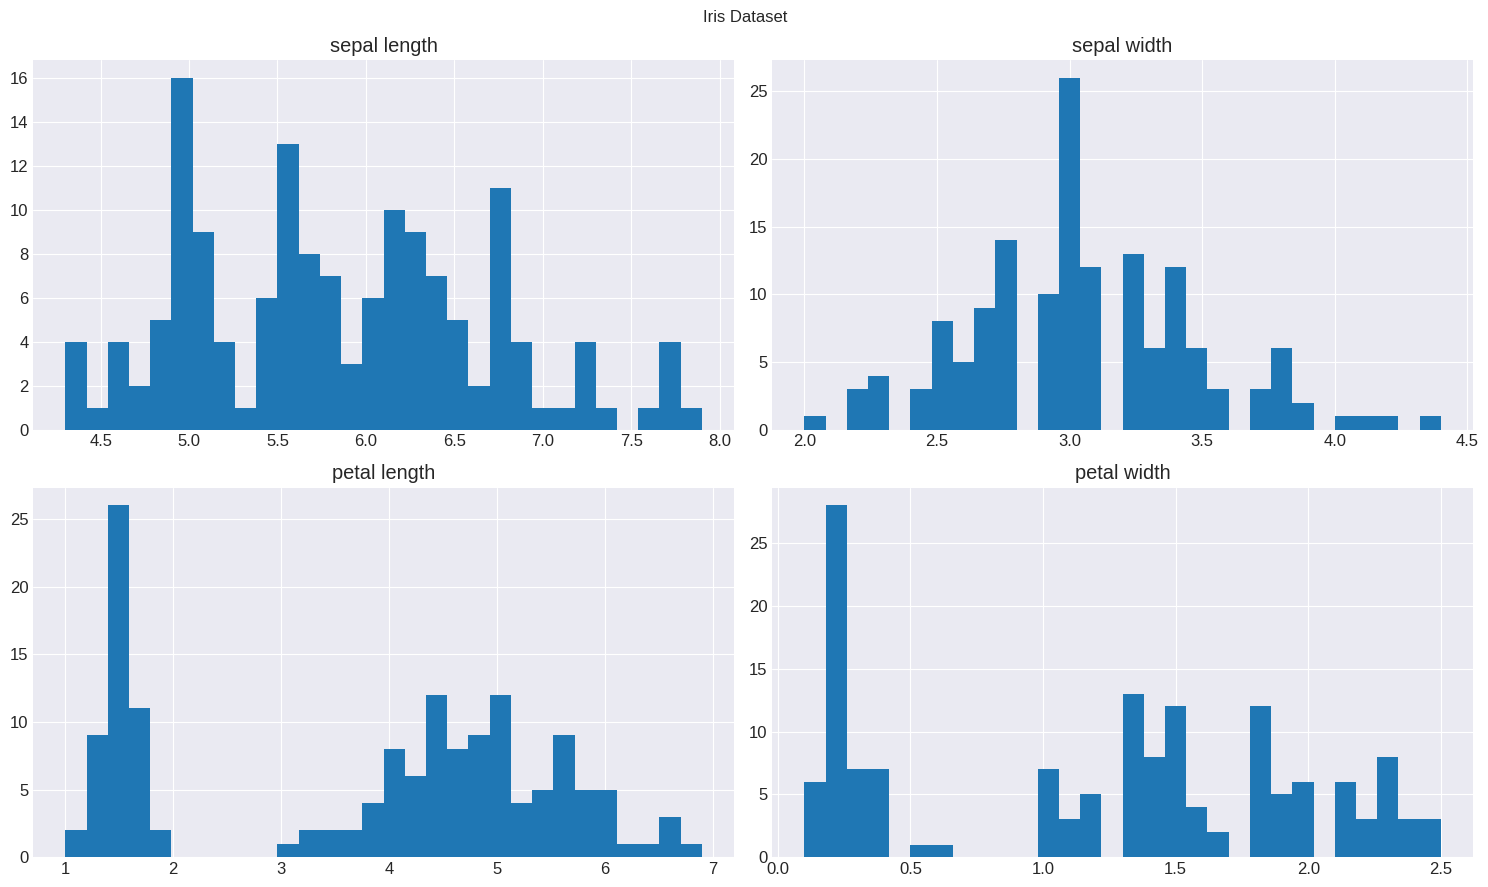

In [9]:
# Plot the features
fig = plt.figure( figsize = (15 , 9) )
fig.suptitle('Iris Dataset')

for count, col in enumerate(iris_df.columns[:-1]):
    
        # Add the first set of axes (subplot 1)
        ax = fig.add_subplot(2, 2, count+1)  # 2 row, 2 columns
                
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        
        n, bins, patches = ax.hist( iris_df [col], 30)
        
        ax.set_title('{}'.format(iris_df.columns[count]))
        
        ax.axis('tight')

plt.tight_layout()

plt.show()

## Feature Extraction

In [10]:
features_df = iris_df.drop('target', axis = 1) # features columns
labels_df = iris_df['target'] # labels

In [11]:
features_df.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [12]:
labels_df.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [13]:
## Function to calculate Mean, Standard Deviation

def fn_calc_mu_std(df):
    '''
    Args:
        df: dataframe
    '''
    mu= {} # dictionary to hold mean
    std_dev = {} # dictionary to hold sigma
    min_val = {} # min value of the col
    max_val = {}
    
    for col in df.columns:
        mu[col] = df[col].mean()
        std_dev[col] = df[col].std()
        min_val[col] = df[col].min()
        max_val[col] = df[col].max()

    return mu, std_dev, min_val, max_val

In [14]:
# Some helpers to format the plot

target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

In [15]:
features_df.iloc[-1]


sepal length    5.9
sepal width     3.0
petal length    5.1
petal width     1.8
Name: 149, dtype: float64

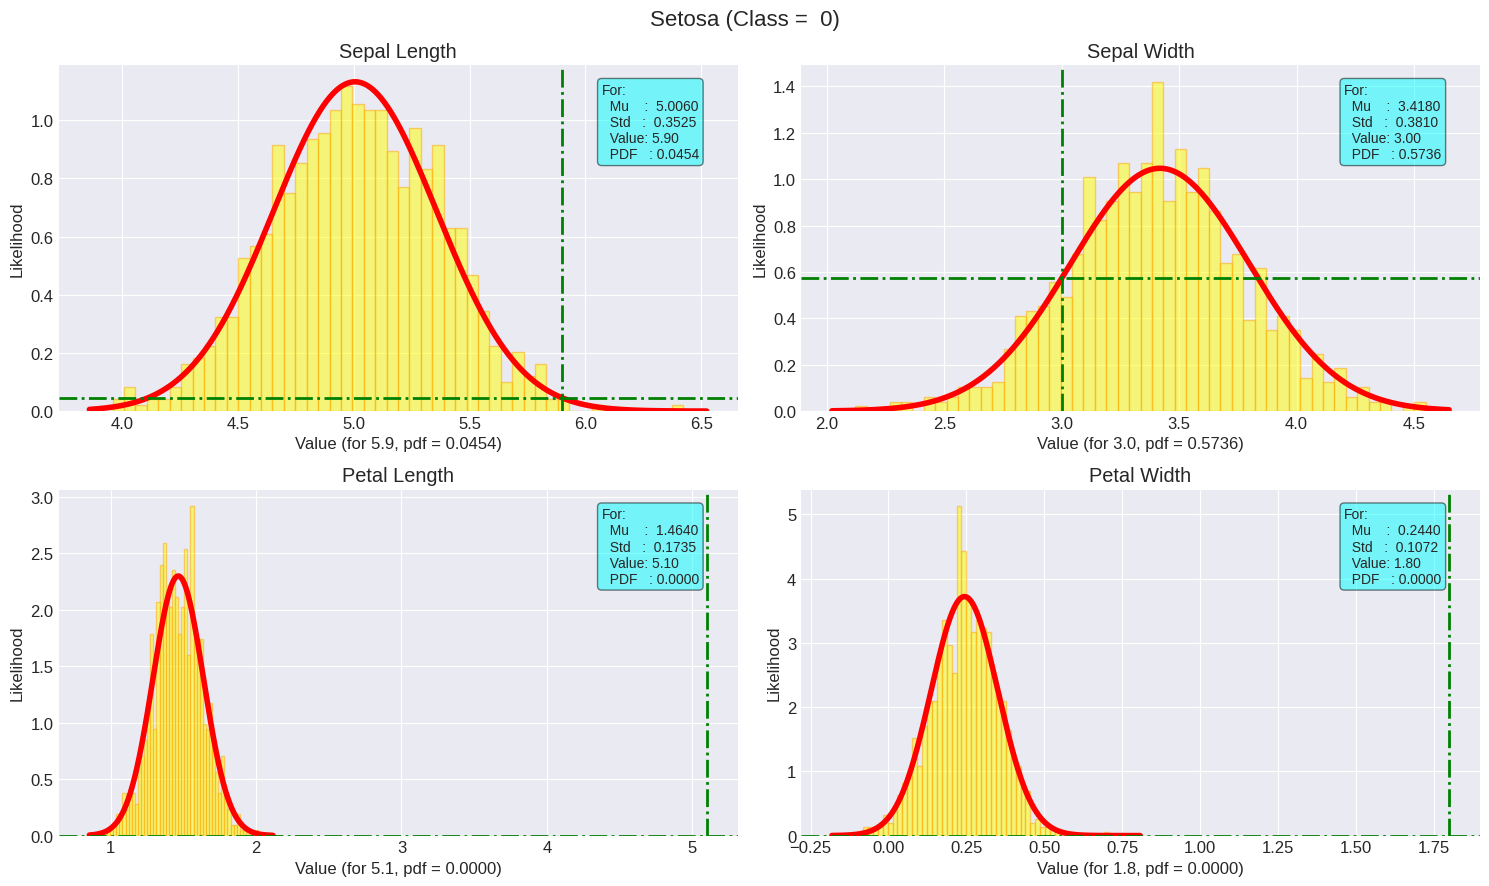

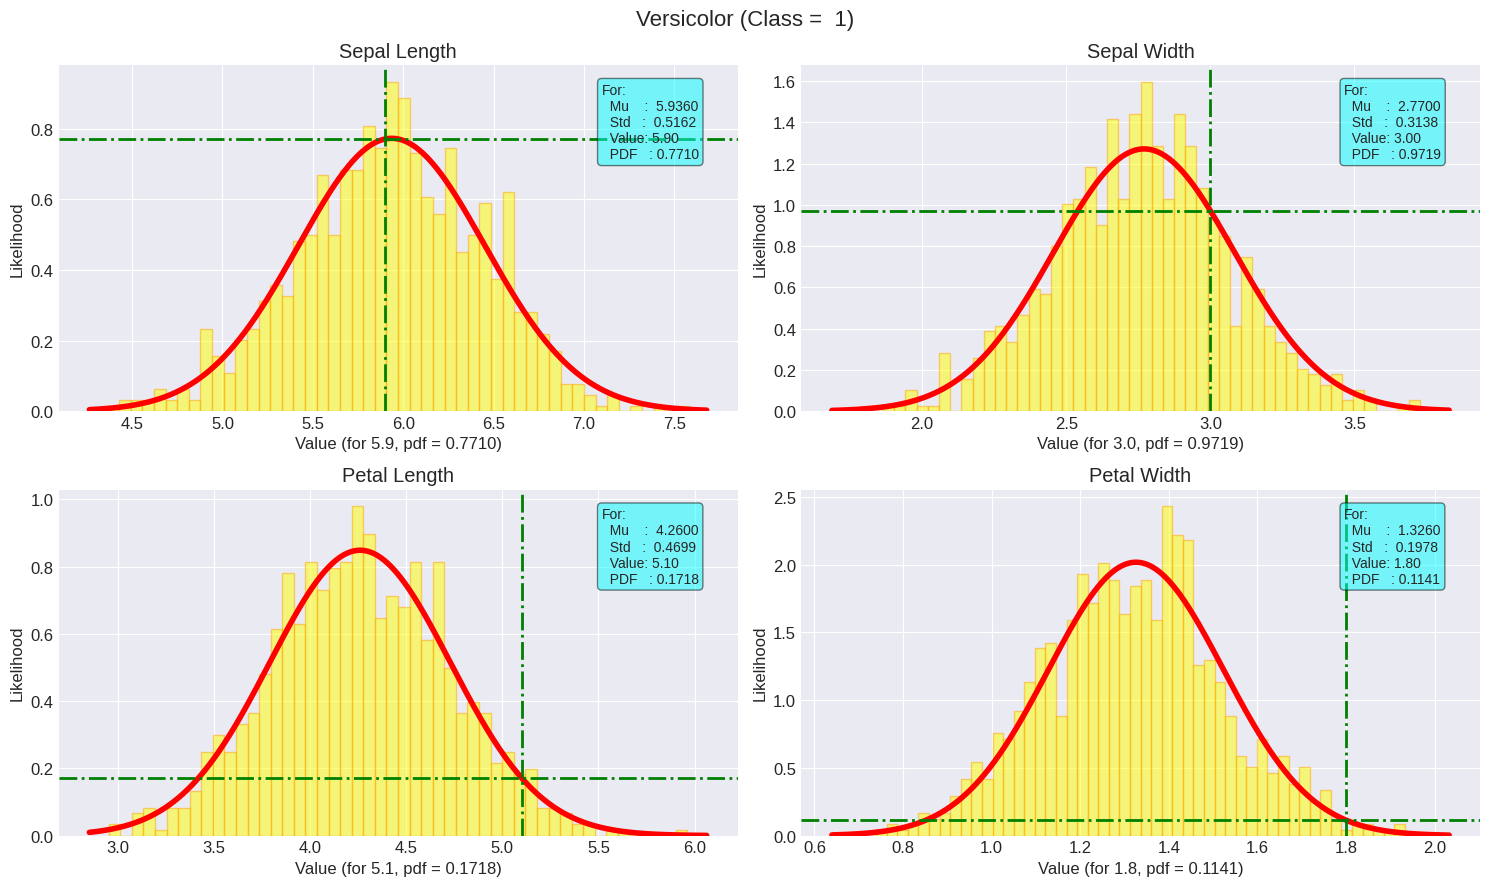

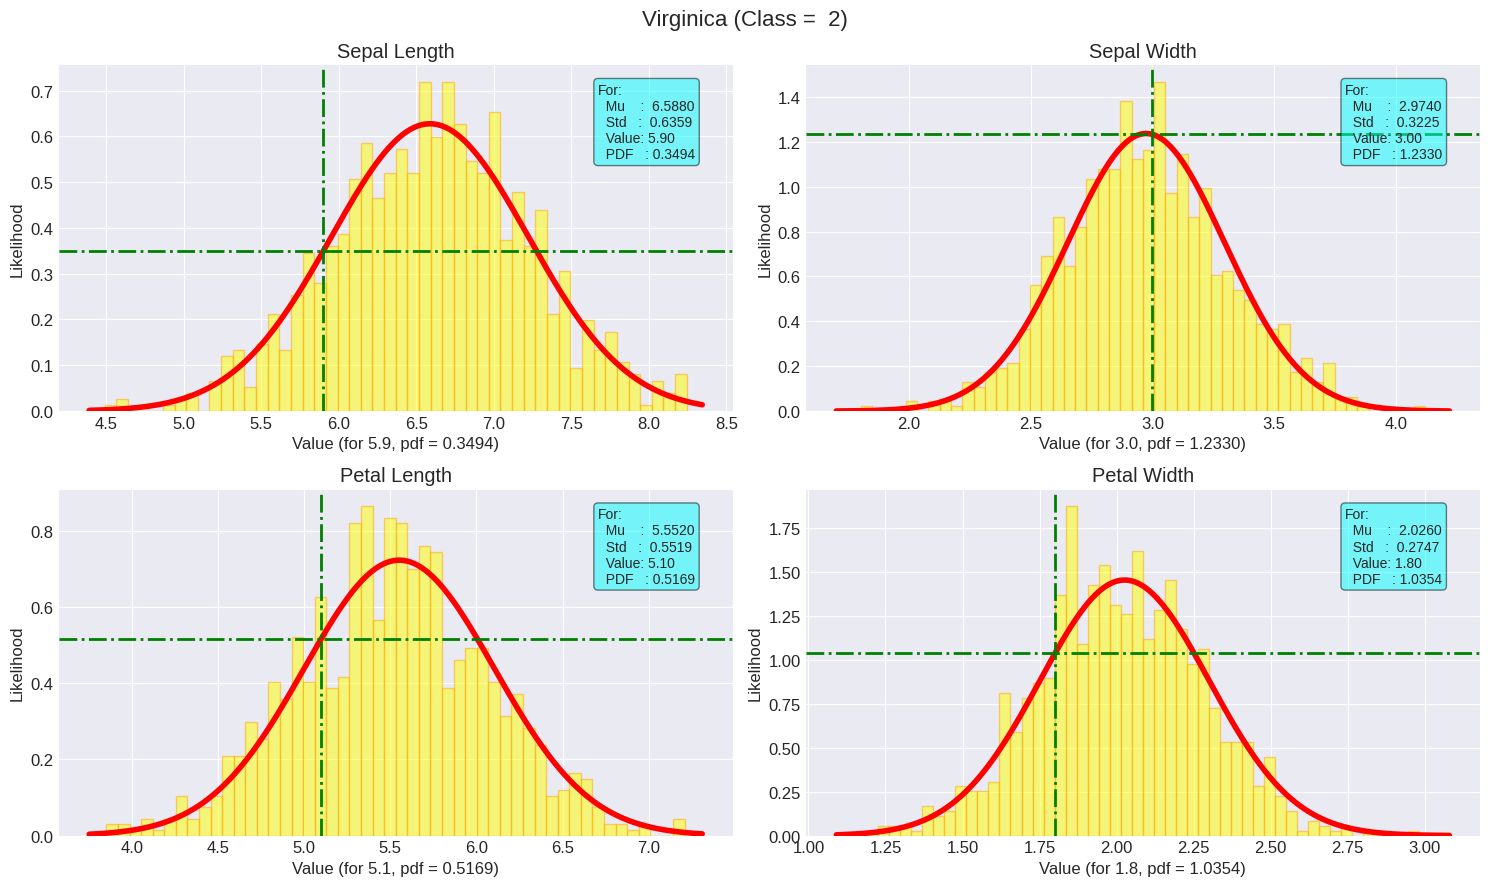

In [16]:
pdf_label = {}

for lbl in iris_df['target'].unique(): # iterate over unique values of the target
    
    label = target_names[lbl] # get name as a string
    
    tmp_df = iris_df[iris_df['target'] == lbl] # dataframe with one class
    
    tmp_df = tmp_df.drop('target', axis = 1) # Remove 'Target' column

    mu, std_dev, min_val, max_val = fn_calc_mu_std(tmp_df) # call fn using this tmp df

    fig, axes = plt.subplots(2,2, figsize = (15 , 9) ) # Plotting is always a good idea!
    
    fig.suptitle(f'{label.title()} (Class = {lbl:2d})', fontsize =16) # title of the figure

    nSample = 1000 # Number of x values for prob. dist. function.
    pdf_col = {} # collect prob. dist. func. for each of the col

    for count, col in enumerate(tmp_df.columns):
        ax = axes.ravel()[count]       # convert from 2D matrix to 1D matrix
        meanVal = mu[col]              # get mean value
        stdDev = std_dev[col]          # get std dev value
        minVal = min_val[col]          # get min
        maxVal = max_val[col]          # get max
        data = np.random.normal(meanVal, stdDev, nSample) # create data around said mean
                
        ax.hist(data, bins=50, density=True, alpha=0.5, color='yellow', edgecolor='Orange')
        
        x = np.linspace(data.min()- 0.1, data.max() + 0.1, nSample) # generate x values
        
        pdf = norm.pdf(x, meanVal, stdDev) # calculate prob. dist. function
        
        ax.plot(x, pdf, 'r-', lw=4)
        
        val = features_df.iloc[-1][col]
        pdf_val = norm.pdf(val, meanVal, stdDev) # given the value what is the probability
        pdf_col[col] = pdf_val

        ax.axvline(x=val, color='g', linestyle='-.', linewidth=2)
        ax.axhline(y=pdf_val, color='g', linestyle='-.', linewidth=2)

        # little beautification
        fmtStr =  "For:\n  Mu    : {:7.4f}\n  Std   : {:7.4f}\n  Value:{:5.2f}\n  PDF   :{:7.4f}"
        txtstr =fmtStr.format(meanVal, stdDev, val, pdf_val) #text to plot
        # place a text box in upper left in axes coords
        
        ax.text(0.8, 0.95, txtstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

        
        ax.set_title(col.title())
        ax.set_xlabel(f"Value (for {val}, pdf = {pdf_val:.4f})")
        ax.set_ylabel("Likelihood")
    pdf_label[ label] = pdf_col
    plt.tight_layout()
    plt.savefig(os.path.join(outDir,f'gaussian_iris_{label}.png'))
    plt.show()

In [17]:
pdf_label

{'setosa': {'sepal length': 0.04538959059205931,
  'sepal width': 0.5736143870495231,
  'petal length': 1.0133390358971727e-95,
  'petal width': 6.753703472451379e-46},
 'versicolor': {'sepal length': 0.7710101202357021,
  'sepal width': 0.9718584132539116,
  'petal length': 0.1717982477055382,
  'petal width': 0.11408115120771109},
 'virginica': {'sepal length': 0.34940711315643136,
  'sepal width': 1.2330295149586672,
  'petal length': 0.5168935071010351,
  'petal width': 1.03537671228938}}

In [18]:
# Iterate and calculate the probabilities
y_pred = [] # create a list for prediction

for k,val_lbl in pdf_label.items(): # iterate
    
    prob = 1 # initialise probability
    
    for k_col, val_col in val_lbl.items():
        
        prob *= val_col # multiply all probs
        
    y_pred.append(prob) # add to the list
    
    print (f'For Label: {k:11s}; likelihood : {prob: 0.4f}')


y_pred = [v/sum(y_pred) for v in y_pred] # Normalize sum to 1

print (f'\nProbabilities : {y_pred}')

For Label: setosa     ; likelihood :  0.0000
For Label: versicolor ; likelihood :  0.0147
For Label: virginica  ; likelihood :  0.2306

Probabilities : [7.265276020022553e-142, 0.05987903023763667, 0.9401209697623633]


In [19]:
iris_df.tail()

,sepal length,sepal width,petal length,petal width,target
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


## using SKLearn

In [22]:
#Make predictions using Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# instantiate
clf = GaussianNB()

# fit the classifier
clf.fit(features_df, labels_df)

# make predictions
y_pred = clf.predict(features_df)

In [26]:
labels = labels_df.to_numpy() # Create a matrix for labels 

# Let's use first two columns of the data and plot the data to visualize the results
xplot = iris_df.keys()[0]

yplot = iris_df.keys()[1]


# also locate instances which are incorrectly predicted.
x_err = iris_df[xplot][(labels != y_pred)]
y_err = iris_df[yplot][(labels != y_pred)]

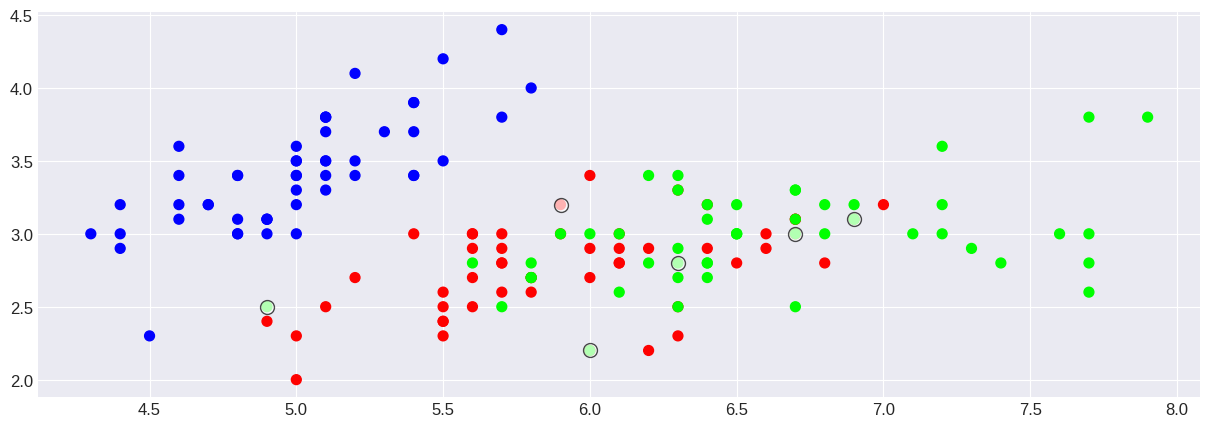

In [30]:
fig = plt.figure()

ax = fig.add_subplot(111)

plt.scatter( iris_df[xplot], iris_df[yplot], s = 50, 
            c = iris_df['target'], 
            cmap=plt.cm.brg);

plt.scatter(x_err, y_err, color = "w", label="mismatch", 
            s = 100, alpha = 0.7, edgecolor = 'black')

In [31]:
accuracy_score(y_pred, labels)

0.96

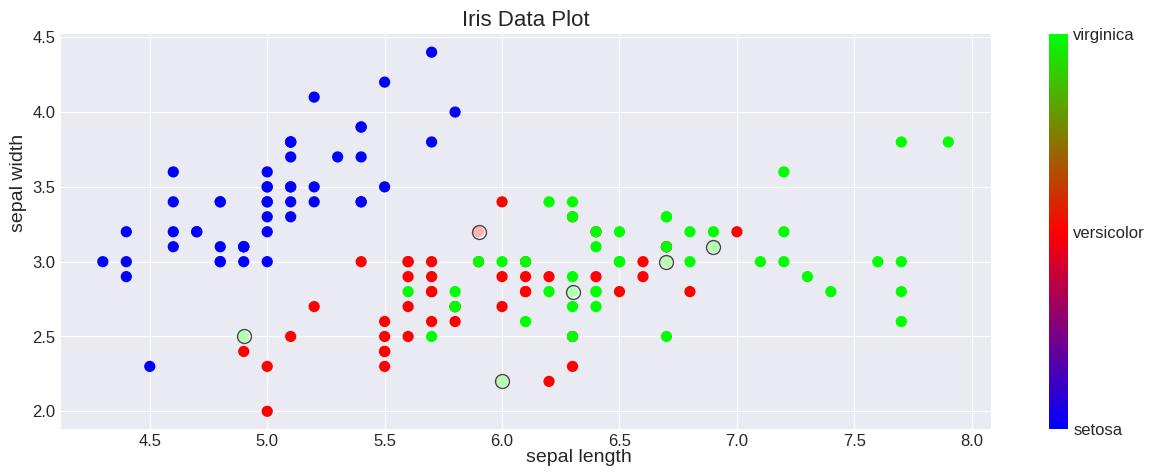

In [32]:
# Plot the data points

# Create a figure of given size
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Iris Data Plot'

plt.scatter( iris_df[xplot], iris_df[yplot], s = 50, 
            c = iris_df['target'], 
            cmap=plt.cm.brg) # , 

plt.colorbar(ticks=[0, 1, 2], format=formatter)

plt.scatter(x_err, y_err, color = "w", label="mismatch", 
            s = 100, alpha = 0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 
# Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')

plt.subplots_adjust(top=0.9)

ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')

ax.set_xlabel(xplot, fontsize=14,  ha='left') 

ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

In [33]:
from sklearn import datasets

In [49]:
N_SAMPLES = 1000
NOISE = 0.0

In [50]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.67874295,  0.73437593],
        [-0.61146339,  0.79127273],
        [ 1.99427795,  0.39317601],
        [-0.98953437,  0.14429736],
        [-0.99873189,  0.05034492]]),
 array([0, 0, 1, 0, 0]))

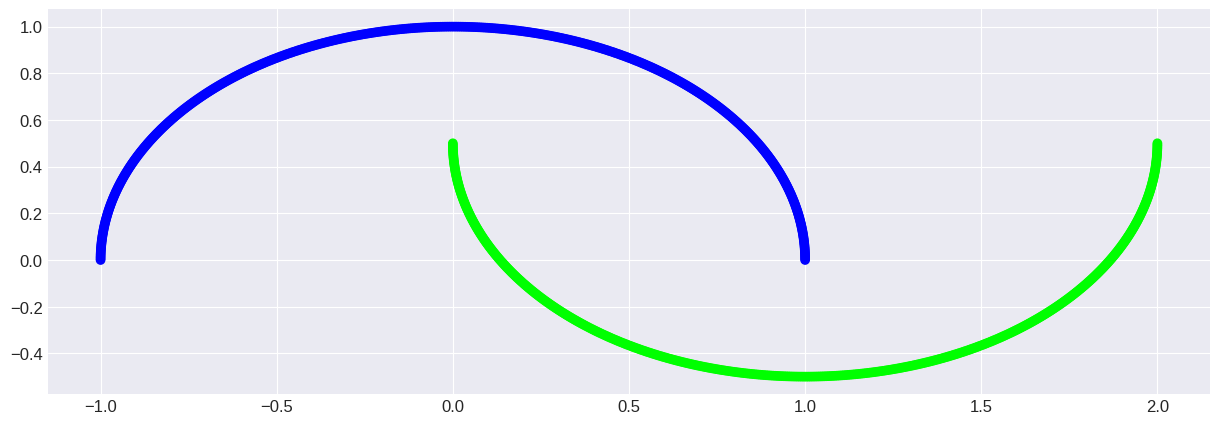

In [51]:
plt.scatter(X[:,0], X[:, 1], c = y, cmap = plt.cm.brg);

In [52]:
# instantiate
clf = BernoulliNB()

# fit the classifier
clf.fit(X, y)

# make predictions
y_pred = clf.predict(X)

In [53]:
accuracy = accuracy_score(y, y_pred)

print ("The accuracy is {:5.3f}".format(accuracy))

The accuracy is 0.831
